# Evaluation

This notebook includes various evaluation metrics of the trained met-ml model. 

In [1]:
%load_ext lab_black

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from dask.distributed import Client
import seaborn as sns

from sklearn.metrics import explained_variance_score, r2_score
import tensorflow as tf
from tensorflow.keras.models import load_model

from joblib import load, dump

from met_ml.train.fluxnet_etl import make_lookback
from met_ml.train.models import transform_df

train_vars = ["P", "t_min", "t_max", "t", "lat", "elev"]
target_vars = ["SW_IN_F", "LW_IN_F", "PA_F", "RH"]
bench_vars = ["shortwave", "longwave", "air_pressure", "rel_humid"]

labels = {
    "shortwave": "Shortwave (W m-2)",
    "longwave": "Longwave (W m-2)",
    "air_pressure": "Air Pressure (kPa)",
    "rel_humid": "Relative Humidity (%%)",
}

lookback = 90

In [3]:
# load fitted transformers and model
fluxnet_df = pd.read_csv(
    "../data/etl/fluxnet.csv",
    index_col=["Unnamed: 0", "TIMESTAMP_START"],
    parse_dates=["TIMESTAMP_START"],
)
meta = pd.read_csv("../data/etl/meta.csv", index_col=0)

test_meta = pd.read_csv("../data/etl/test_meta.csv", index_col=0)

trans = load("../data/etl/fluxnet_all_transformers.joblib")

In [5]:
models = {
    var: load_model(f"./best_3_layer_lstm_wide_{var}.h5", compile=False)
    for var in target_vars
}

In [6]:
df_trans = transform_df(trans, fluxnet_df)

In [7]:
df_trans.head()

P     t_min     t_max   SW_IN_F   LW_IN_F      PA_F  \
       TIMESTAMP_START                                                          
AR-SLu 2009-01-01       0.0  1.128932  0.690825  0.183470  0.762338  0.722481   
       2009-01-02       0.0  1.027457  0.936208  0.590219  0.733104  0.730062   
       2009-01-03       0.0  0.967795  1.247784  0.793757  0.676937  0.731395   
       2009-01-04       0.0  1.289733  1.502405  0.951432  0.654861  0.721926   
       2009-01-05       0.0  1.397325  1.412009  0.709380  0.728502  0.713997   

                        RH         t       lat      elev  
       TIMESTAMP_START                                    
AR-SLu 2009-01-01      NaN  1.000000 -0.551425  0.100129  
       2009-01-02      NaN  0.999852 -0.551425  0.100129  
       2009-01-03      NaN  0.999408 -0.551425  0.100129  
       2009-01-04      NaN  0.998669 -0.551425  0.100129  
       2009-01-05      NaN  0.997634 -0.551425  0.100129

In [8]:
def inverse_transform(transformers, df):
    out = pd.DataFrame(index=df.index)
    for key in df:
        out[key] = transformers[key].inverse_transform(df[[key]])
    return out

In [12]:
eval_data = {}

for name in test_meta.index.values:  # only predicting val data sites
    print(name)
    xdf = df_trans.loc[name, train_vars]
    x = make_lookback(xdf, lookback)
    predicted = pd.DataFrame(index=xdf.index[lookback - 1 :])
    for var, model in models.items():
        with tf.device("/GPU:0"):
            predicted[var] = model.predict(x.values)
    eval_data[name] = inverse_transform(trans, predicted)

AU-Wac
AU-Ync
AU-Gin
AU-TTE
AU-Dry
AU-Fog
GH-Ank
SN-Dhr
CN-Dan
US-SRC
US-ARc
US-AR2
CN-HaM
US-Tw1
US-Blo
IT-Noe
US-GLE
IT-Cp2
CN-Du2
IT-Ro2
CA-TP1
IT-SR2
US-Me5
FR-LBr
IT-Isp
IT-MBo
US-Wi0
US-Wi2
CH-Fru
CH-Lae
CZ-wet
BE-Vie
DE-Gri
DE-Lnf
DE-Akm
CA-SF1
CA-NS1
RU-Fyo
FI-Hyy
FI-Sod
US-Atq
DK-ZaF


In [55]:
x

<xarray.DataArray (samples: 1372, lookback: 90, features: 6)>
array([[[ 1.85663553e+00, -2.23281004e+00, -2.06816268e+00,
          1.00000000e+00,  9.63543789e-01,  4.94173500e-02],
        [ 0.00000000e+00, -2.32674340e+00, -2.25292486e+00,
          9.99852042e-01,  9.63543789e-01,  4.94173500e-02],
        [ 0.00000000e+00, -2.53932942e+00, -2.55740072e+00,
          9.99408212e-01,  9.63543789e-01,  4.94173500e-02],
        ...,
        [ 0.00000000e+00, -2.53539109e+00, -2.33614419e+00,
          7.41174252e-02,  9.63543789e-01,  4.94173500e-02],
        [ 0.00000000e+00, -2.23691596e+00, -2.33278488e+00,
          5.69521960e-02,  9.63543789e-01,  4.94173500e-02],
        [ 0.00000000e+00, -2.18613664e+00, -2.25552069e+00,
          3.97701138e-02,  9.63543789e-01,  4.94173500e-02]],

       [[ 0.00000000e+00, -2.32674340e+00, -2.25292486e+00,
          9.99852042e-01,  9.63543789e-01,  4.94173500e-02],
        [ 0.00000000e+00, -2.53932942e+00, -2.55740072e+00,
          9.99408212e-01,  9.63543789e-01,  4.94173500e-02],
        [ 0.00000000e+00, -2.05918835e+00, -2.18375356e+00,
          9.98668640e-01,  9.63543789e-01,  4.94173500e-02],
        ...,
        [ 0.00000000e+00, -2.23691596e+00, -2.33278488e+00,
          5.69521960e-02,  9.63543789e-01,  4.94173500e-02],
        [ 0.00000000e+00, -2.18613664e+00, -2.25552069e+00,
          3.97701138e-02,  9.63543789e-01,  4.94173500e-02],
        [ 0.00000000e+00, -2.17582995e+00, -2.39592468e+00,
          2.25762630e-02,  9.63543789e-01,  4.94173500e-02]],

       [[ 0.00000000e+00, -2.53932942e+00, -2.55740072e+00,
          9.99408212e-01,  9.63543789e-01,  4.94173500e-02],
        [ 0.00000000e+00, -2.05918835e+00, -2.18375356e+00,
          9.98668640e-01,  9.63543789e-01,  4.94173500e-02],
        [ 0.00000000e+00, -1.76372981e+00, -1.87171925e+00,
          9.97633547e-01,  9.63543789e-01,  4.94173500e-02],
        ...,
        [ 0.00000000e+00, -2.18613664e+00, -2.25552069e+00,
          3.97701138e-02,  9.63543789e-01,  4.94173500e-02],
        [ 0.00000000e+00, -2.17582995e+00, -2.39592468e+00,
          2.25762630e-02,  9.63543789e-01,  4.94173500e-02],
        [ 0.00000000e+00, -2.33604456e+00, -2.21032267e+00,
          5.37573156e-03,  9.63543789e-01,  4.94173500e-02]],

       ...,

       [[ 1.88520363e+00, -7.98503808e-01, -9.83104776e-01,
         -1.61265733e-02,  9.63543789e-01,  4.94173500e-02],
        [ 6.69432950e-01, -8.02693521e-01, -1.15259736e+00,
          1.07515128e-03,  9.63543789e-01,  4.94173500e-02],
        [ 1.06265857e+00, -7.67499934e-01, -1.28696985e+00,
          1.82765577e-02,  9.63543789e-01,  4.94173500e-02],
        ...,
        [ 1.58740105e+00, -2.17524339e+00, -1.83667552e+00,
          9.95924577e-01,  9.63543789e-01,  4.94173500e-02],
        [ 0.00000000e+00, -2.88749454e+00, -2.63069481e+00,
          9.97328632e-01,  9.63543789e-01,  4.94173500e-02],
        [ 4.64158883e-01, -2.92939167e+00, -3.07351326e+00,
          9.98437562e-01,  9.63543789e-01,  4.94173500e-02]],

       [[ 6.69432950e-01, -8.02693521e-01, -1.15259736e+00,
          1.07515128e-03,  9.63543789e-01,  4.94173500e-02],
        [ 1.06265857e+00, -7.67499934e-01, -1.28696985e+00,
          1.82765577e-02,  9.63543789e-01,  4.94173500e-02],
        [ 6.69432950e-01, -7.33144290e-01, -1.11365987e+00,
          3.54725558e-02,  9.63543789e-01,  4.94173500e-02],
        ...,
        [ 0.00000000e+00, -2.88749454e+00, -2.63069481e+00,
          9.97328632e-01,  9.63543789e-01,  4.94173500e-02],
        [ 4.64158883e-01, -2.92939167e+00, -3.07351326e+00,
          9.98437562e-01,  9.63543789e-01,  4.94173500e-02],
        [ 4.64158883e-01, -2.96290937e+00, -2.86737363e+00,
          9.99251037e-01,  9.63543789e-01,  4.94173500e-02]],

       [[ 1.06265857e+00, -7.67499934e-01, -1.28696985e+00,
          1.82765577e-02,  9.63543789e-01,  4.94173500e-02],
        [ 6.69432950e-01, -7.33144290e-01, -1.11365987e+00,
          3.54725558e-02,  9.63543789e-

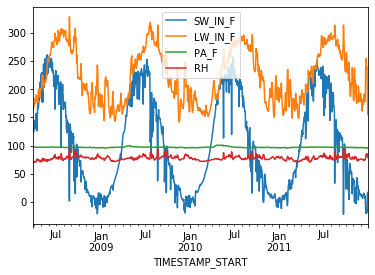

In [14]:
eval_data[name].plot()

In [15]:
bench_data = {}
# var_list = ['', 'shortwave', 'longwave']
for name in eval_data.keys():
    fname = f"../data/metsim/metsim_{name}_DD.csv"
    try:
        df = pd.read_csv(fname, parse_dates=True, index_col=0)
        bench_data[name] = df
    except:
        print(fname)

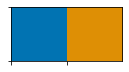

In [16]:
colors = sns.color_palette("colorblind", n_colors=2)
sns.palplot(colors)

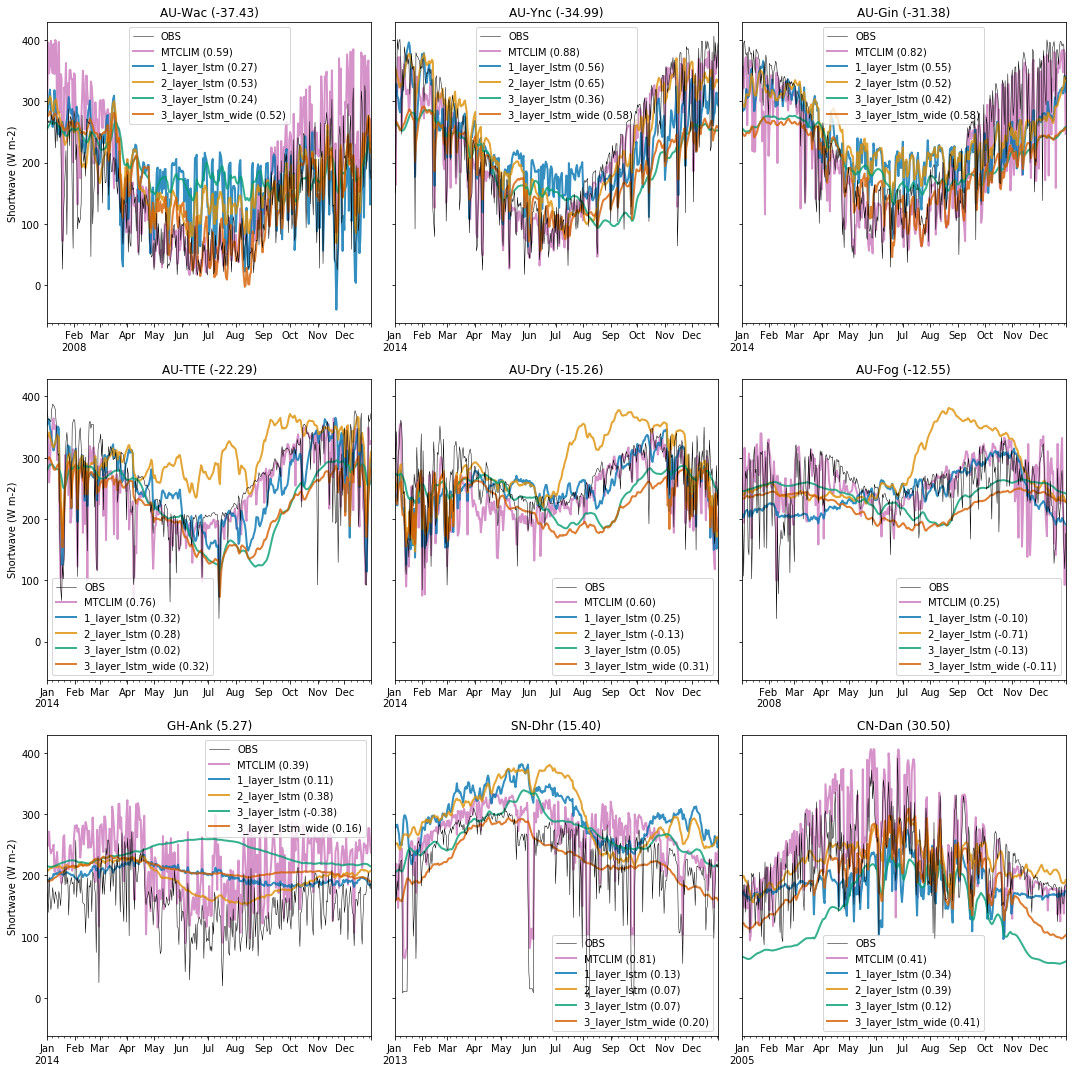

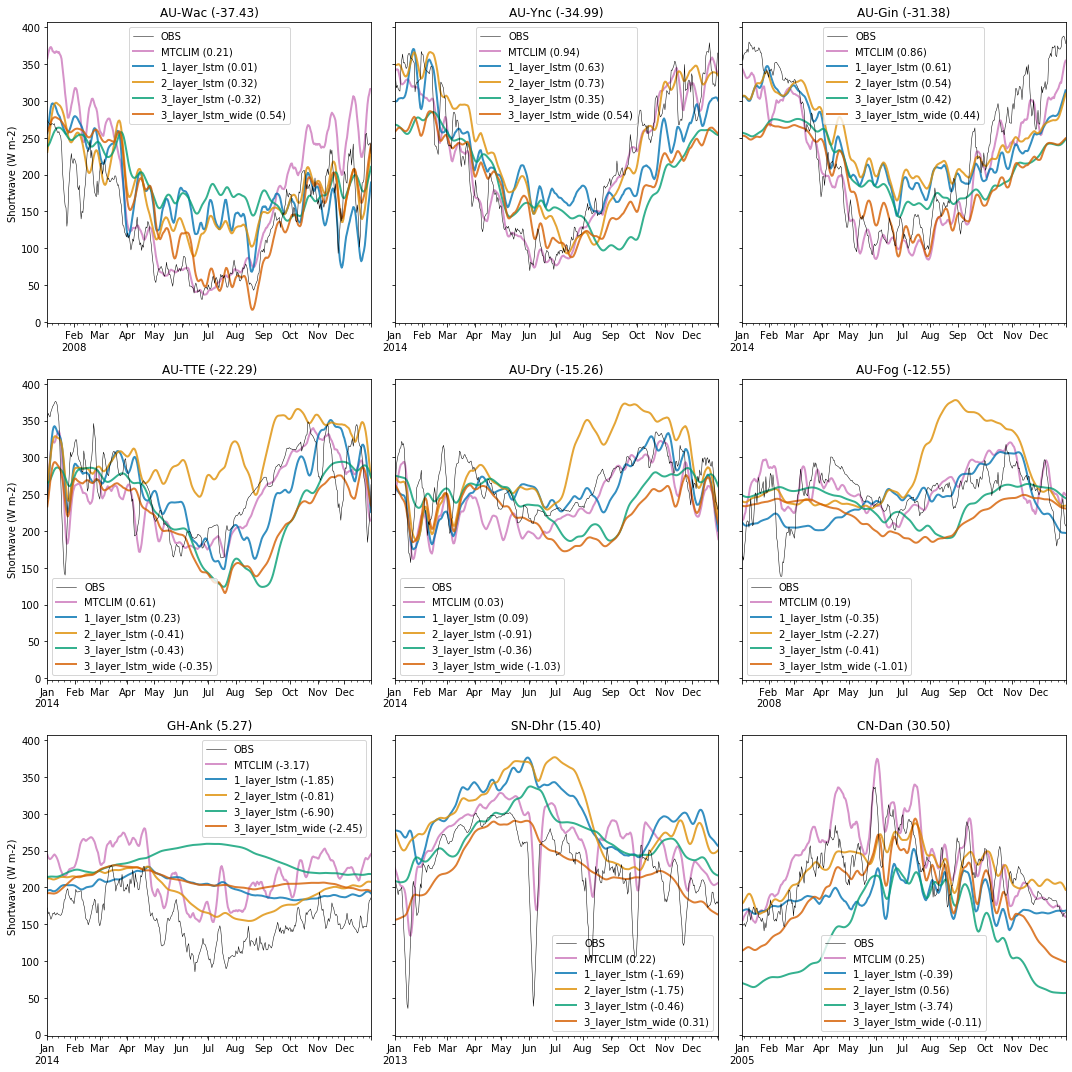

In [62]:
# last_n = -365 * 1

# fluxn_var = "SW_IN_F"
# bench_var = "shortwave"

# style = {
#     "OBS": dict(c="k", lw=0.5, zorder=10),
#     "MTCLIM": dict(c=colors[-1], lw=2, alpha=0.8),
# }
# for i, modname in enumerate(models):
#     style[modname] = dict(c=colors[i], lw=2, alpha=0.8)


# fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=False, sharey=True)

# for ax, (name, site_meta) in zip(axes.flat, test_meta.iterrows()):
#     obs_series = fluxnet_df.loc[name, fluxn_var].iloc[last_n:]
#     obs_series.plot(label="OBS", ax=ax, **style["OBS"])

#     mod_data = [("MTCLIM", bench_data[name][bench_var])]
#     for modname in models:
#         mod_data.append((modname, eval_data[modname, name][fluxn_var]))

#     for kind, series in mod_data:
#         data = series.iloc[last_n:]
#         skill = explained_variance_score(obs_series.values, data.values)
#         data.plot(ax=ax, label=f"{kind} ({skill:0.2f})", **style[kind])
#     ax.legend()
#     ax.set_xlabel("")
#     lat = site_meta["lat"]
#     ax.set_title(f"{name} ({lat:.2f})")

# for ax in axes[:, 0]:
#     ax.set_ylabel("Shortwave (W m-2)")

# fig.tight_layout()
# # fig.savefig("results_daily.png", dpi=300)
# plt.show()
# plt.close("all")

# rolling = 7
# fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=False, sharey=True)

# for ax, (name, site_meta) in zip(axes.flat, test_meta.iterrows()):
#     obs_series = fluxnet_df.loc[name, fluxn_var].rolling(rolling).mean().iloc[last_n:]
#     obs_series.plot(label="OBS", ax=ax, **style["OBS"])

#     mod_data = [("MTCLIM", bench_data[name][bench_var])]
#     for modname in models:
#         mod_data.append((modname, eval_data[modname, name][fluxn_var]))

#     for kind, series in mod_data:
#         data = series.rolling(rolling).mean().rolling(rolling).mean().iloc[last_n:]
#         skill = r2_score(obs_series.values, data.values)
#         data.plot(ax=ax, label=f"{kind} ({skill:0.2f})", **style[kind])
#     ax.legend()
#     ax.set_xlabel("")
#     lat = site_meta["lat"]
#     ax.set_title(f"{name} ({lat:.2f})")

# for ax in axes[:, 0]:
#     ax.set_ylabel("Shortwave (W m-2)")

# fig.tight_layout()
# # fig.savefig("results_daily_rolling.png", dpi=300)
# plt.show()
# plt.close("all")

In [45]:
def calc_skill(a, b):
    df = pd.DataFrame({"a": a, "b": b}).dropna()
    return explained_variance_score(df.a.values, df.b.values)


def panel_plot(fluxn_var, bench_var, fluxnet_df, bench_data, eval_data, rolling=1):

    last_n = -365 * 1

    style = {
        "OBS": dict(c="k", lw=0.5, zorder=10),
        "MTCLIM": dict(c=colors[-1], lw=2, alpha=0.8),
        "LSTM": dict(c=colors[0], lw=2, alpha=0.8),
    }

    fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=False, sharey=True)

    for ax, (name, site_meta) in zip(axes.flat, test_meta.iterrows()):
        obs_series = (
            fluxnet_df.loc[name, fluxn_var].rolling(rolling).mean().iloc[last_n:]
        )
        obs_series.plot(label="OBS", ax=ax, **style["OBS"])

        mod_data = [
            ("MTCLIM", bench_data[name][bench_var]),
            ("LSTM", eval_data[name][fluxn_var]),
        ]

        for kind, series in mod_data:
            data = series.rolling(rolling).mean().iloc[last_n:]
            skill = calc_skill(obs_series, data)
            data.plot(ax=ax, label=f"{kind} ({skill:0.2f})", **style[kind])

        ax.legend()
        ax.set_xlabel("")
        lat = site_meta["lat"]
        ax.set_title(f"{name} ({lat:.2f})")

    for ax in axes[:, 0]:
        ax.set_ylabel(labels[bench_var])

    fig.tight_layout()

    return fig

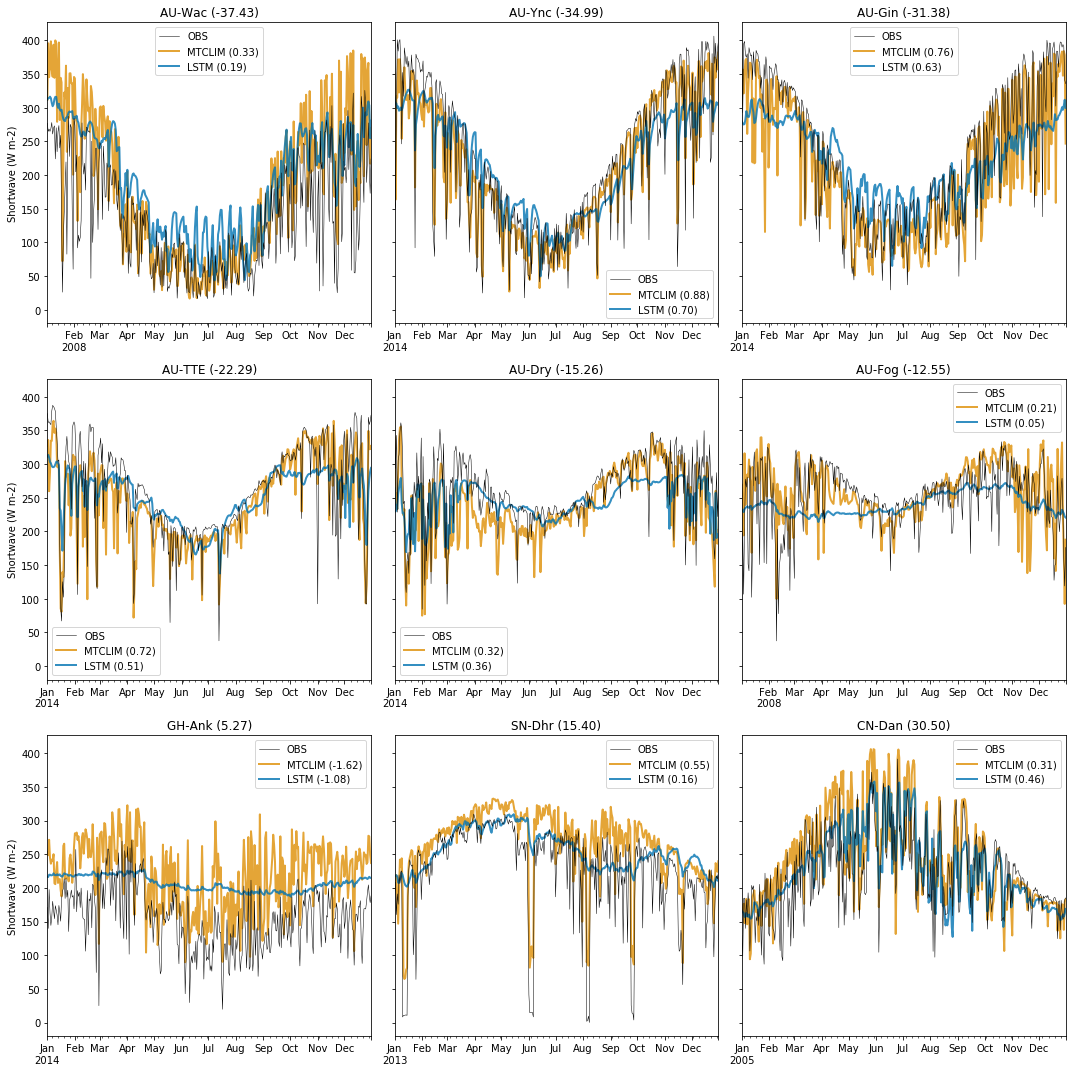

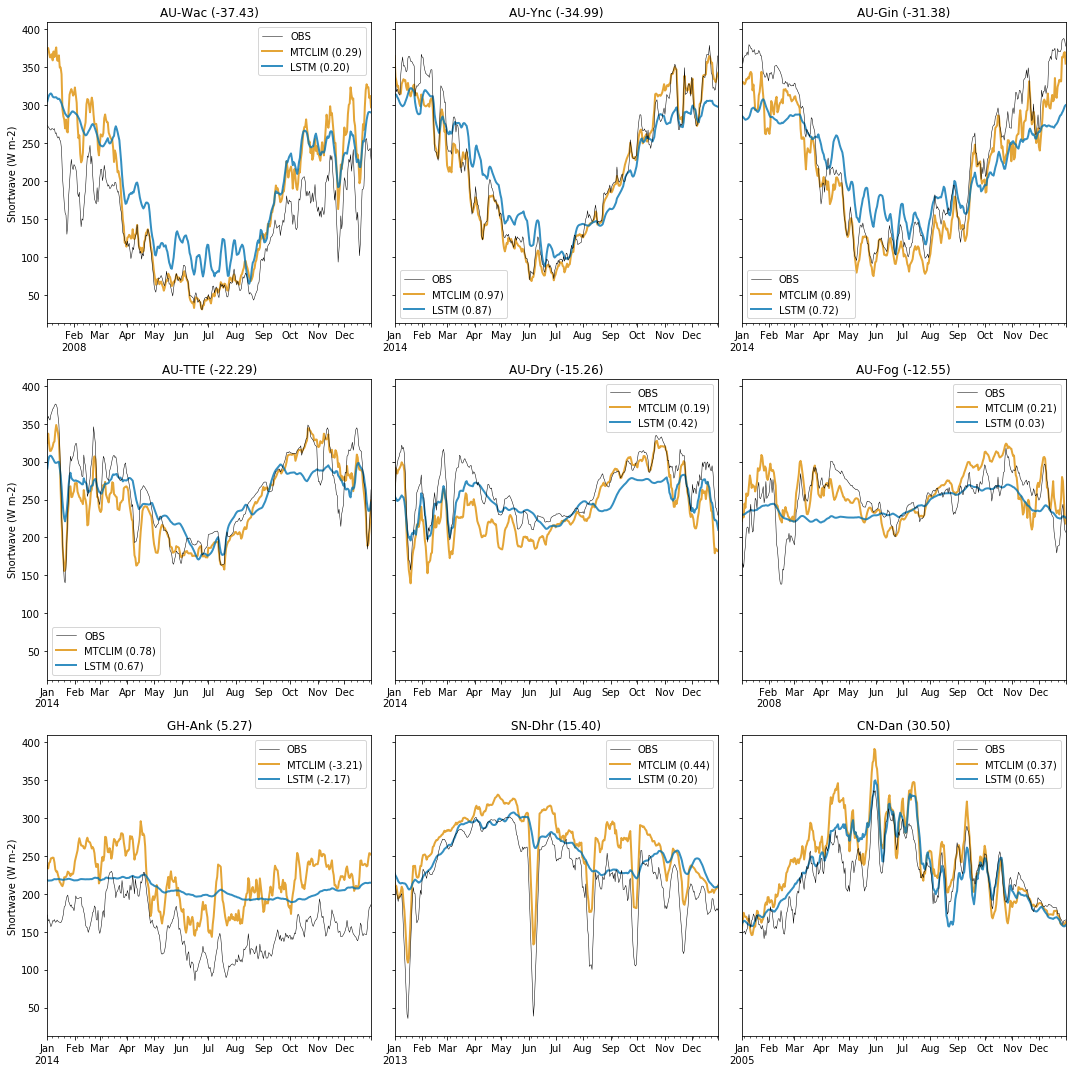

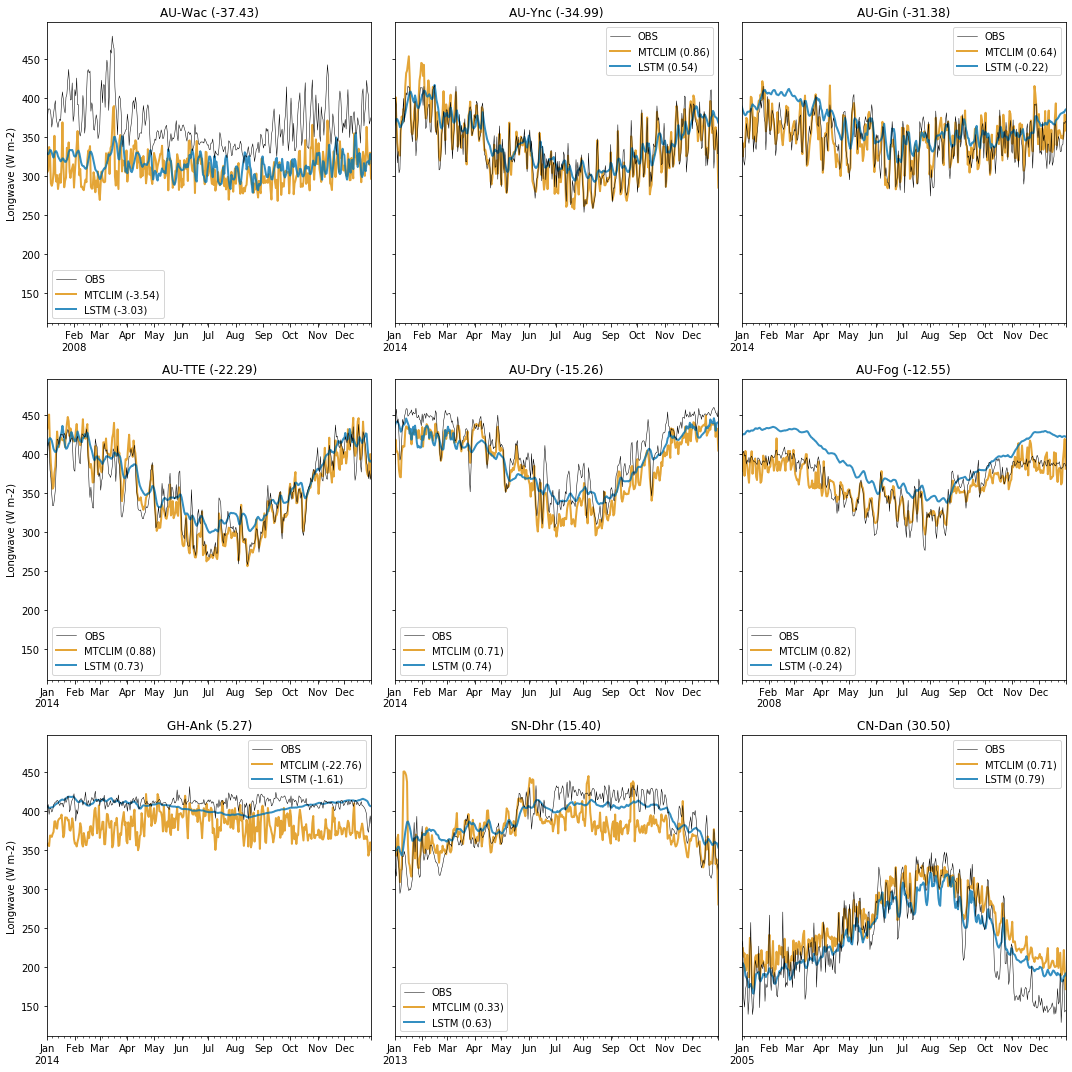

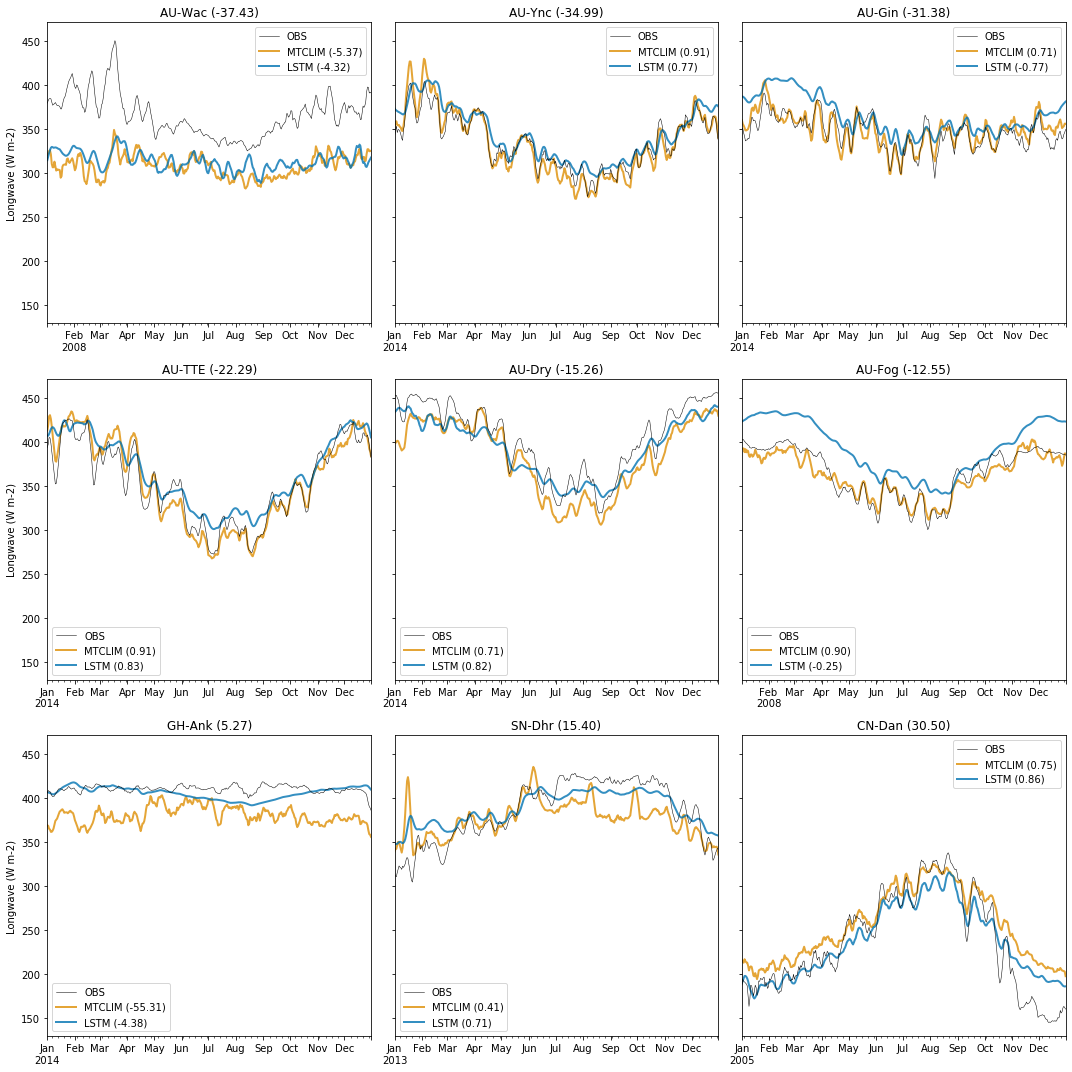

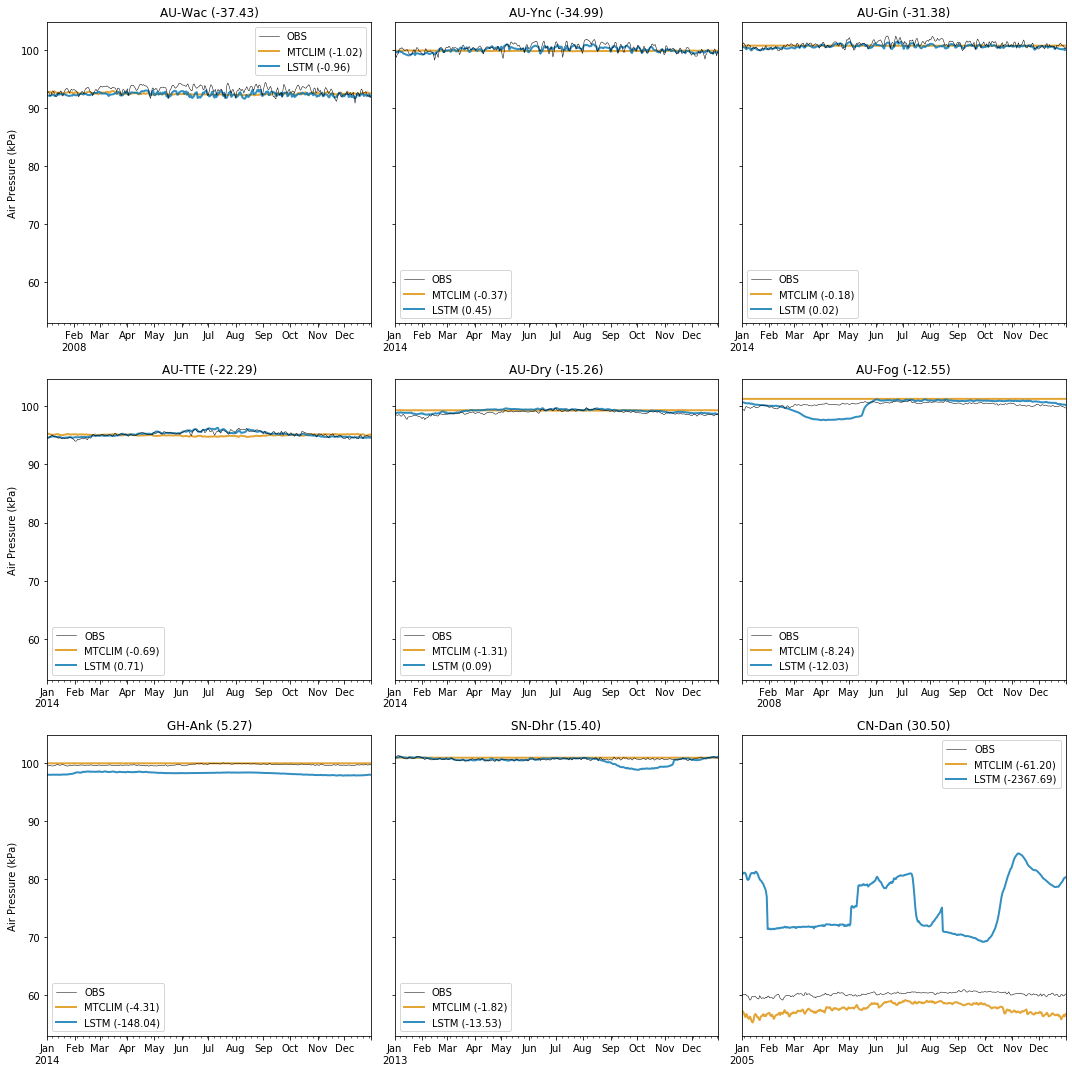

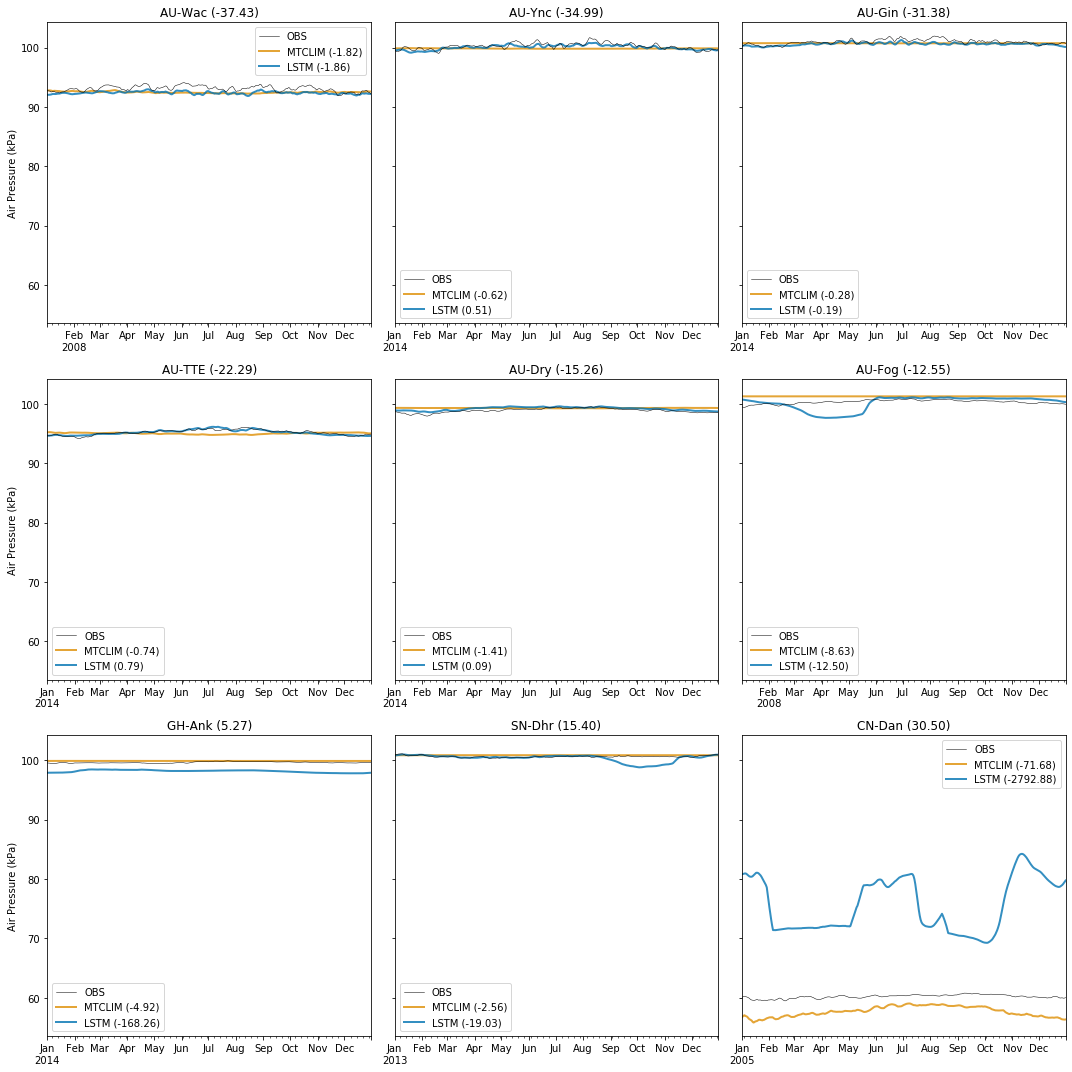

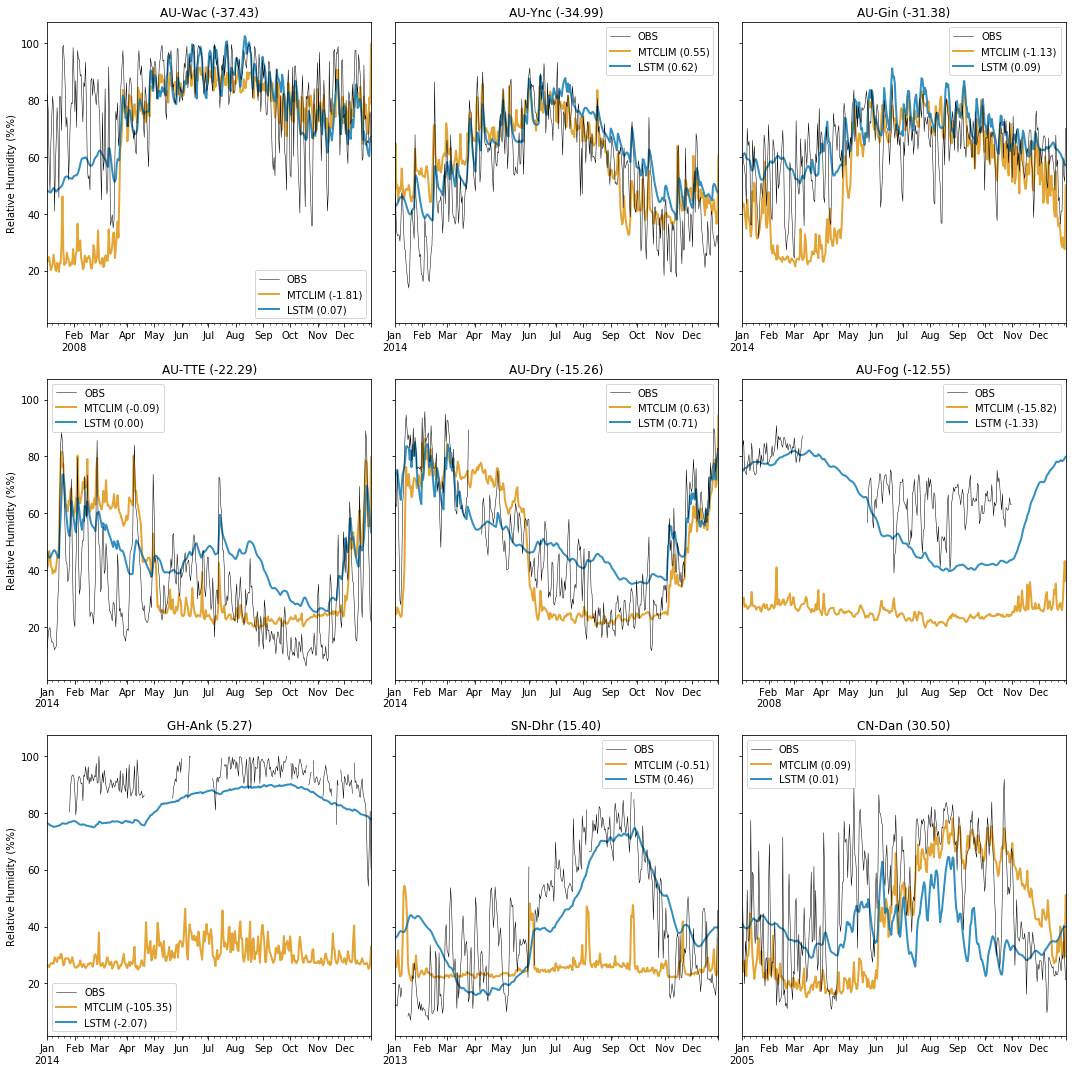

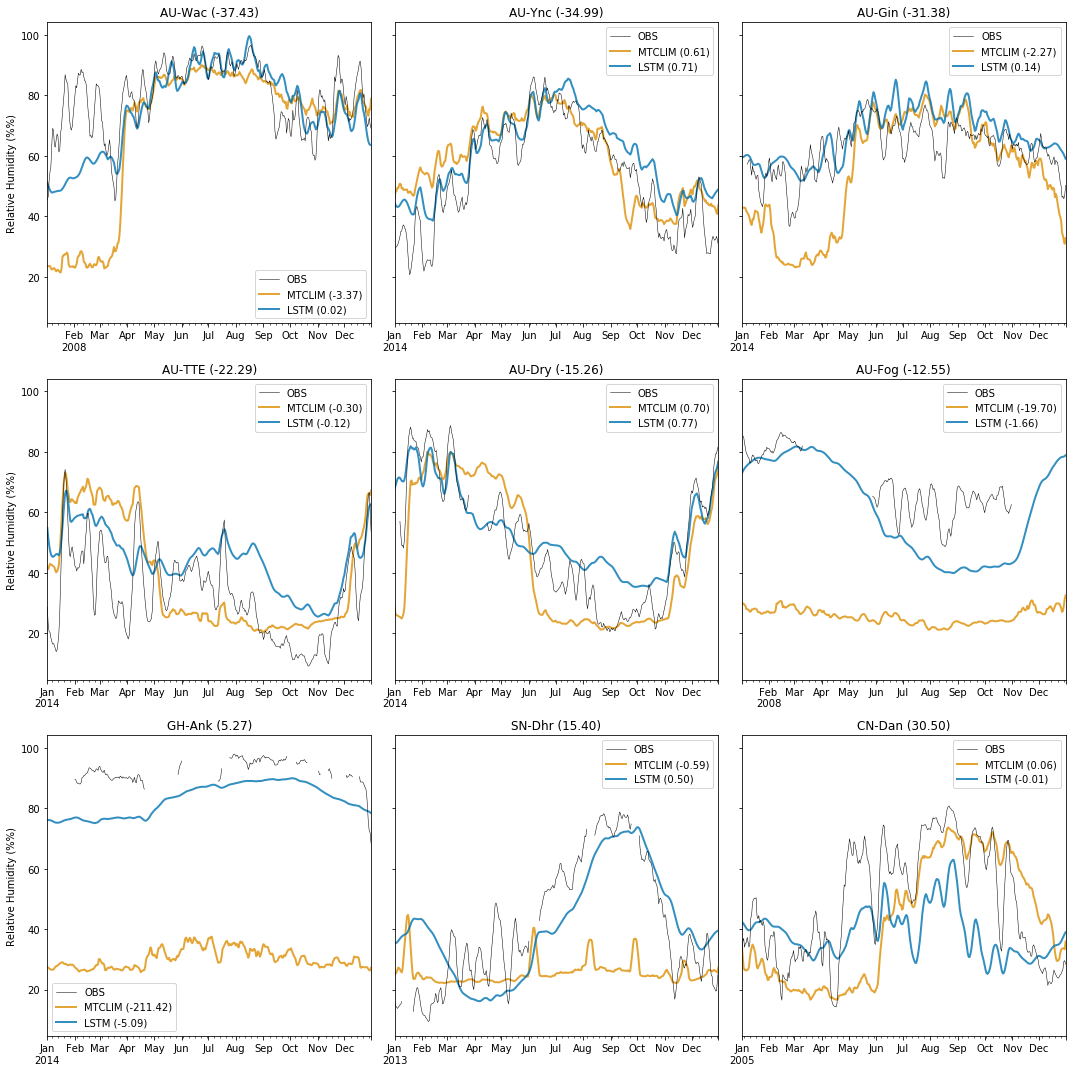

In [49]:
# TODO: calc for all variables
perf = pd.DataFrame(columns=["LW_IN_F", "SW_IN_F"], index=eval_data.keys())

for var in perf.columns:
    for name, df in eval_data.items():
        perf.loc[name, var] = explained_variance_score(
            *obs_data[name][var].align(df[var], join="inner")
        )

In [48]:
# TODO: calc for all variables
perf = pd.DataFrame(columns=['LW_IN_F', 'SW_IN_F'], index=eval_data.keys())

for var in perf.columns:
    for name, df in eval_data.items():
        perf.loc[name, var] = explained_variance_score(*obs_data[name][var].align(df[var], join='inner'))

NameError: name 'obs_data' is not defined

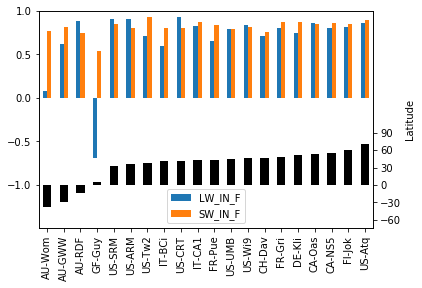

In [111]:
df = pd.merge(perf, meta, left_index=True, right_index=True)

ax = df[['LW_IN_F', 'SW_IN_F']].plot.bar()
ax2 = ax.twinx() 
df.lat.plot.bar(ax=ax2, color='k')
ax.set_ylim(-1.5, 1)
ax.set_yticks(np.arange(-1, 1.1, .5))
ax2.set_ylim(-75, 300)
ax2.set_ylabel('Latitude')
ax2.set_yticks(np.arange(-60, 91, 30))
ax.legend(loc=8)

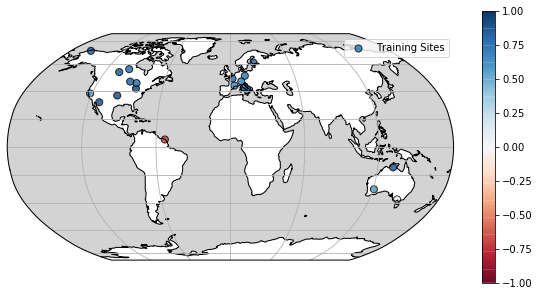

In [76]:
import cartopy
import cartopy.crs as ccrs

fig = plt.figure(figsize=(10,10))


ax = fig.add_subplot(1, 1, 1,
                     projection=ccrs.Robinson())
m = ax.scatter(df.lon, df.lat, c=df['LW_IN_F'].values, cmap='RdBu', edgecolors='k',
           transform=ccrs.PlateCarree(), label='Training Sites', vmin=-1, vmax=1, s=50, alpha=0.8)
ax.set_global()
# ax.stock_img()
ax.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='lightgray')
# ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
plt.colorbar(m, shrink=0.5)
# ax.
ax.coastlines()
ax.gridlines()
ax.legend()

In [53]:
model.input

[]

In [61]:
!ls /glade/u/home/jhamman/.local/share/cartopy

gshhs  natural_earth


In [78]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_file
from joblib import load  # TODO: move to onnx

from met_ml.train.models import transform_df
from met_ml.train.fluxnet_etl import make_lookback


VERSION = "v0.1"  # TODO import this from metml package
WEIGHTS_PATH = f"https://github.com/jhamman/met-ml/releases/download/{VERSION}/"
WEIGHTS_FILE = "met-ml_weights_tf_{var}.h5"
CACHE_SUBDIR = f"met-ml/{VERSION}"


def get_model(var):
    return get_file(
        WEIGHTS_FILE.format(var=var),
        (WEIGHTS_PATH + WEIGHTS_FILE).format(var=var),
        cache_subdir=CACHE_SUBDIR,
    )